In [3]:
# Imports
import pandas as pd
import yfinance as yf
import numpy as np
from pandas_datareader import data as pdr
import datetime
import matplotlib.pyplot as plt
import numba as nb
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, classification_report, roc_auc_score

import os
import sys
module_path = os.path.abspath(os.path.join('../'))
if module_path not in sys.path:
    sys.path.append(module_path)
from notebooks.mlfinlab.corefns.core_functions import CoreFunctions
from notebooks.mlfinlab.corefns.financial_functions import FinancialFunctions

In [4]:
# Functions

#Cargamos ambos files y los unimos, usando como indices en ambos las fechas.
def load_and_join():
    mtum = yf.Ticker("MTUM")
    stocks = ["MTUM"]
    start = datetime.datetime(2000,11,30)
    end = datetime.datetime(2019,11,30)
    
    yf.pdr_override()
    
    df_etf = pdr.get_data_yahoo(stocks, start=start, end=end)
    
    df = pd.read_excel('https://images.aqr.com/-/media/AQR/Documents/Insights/Data-Sets/Century-of-Factor-Premia-Monthly.xlsx',
                      header =18, nrows = 1220)
    
    df['Date'] =  pd.to_datetime(df['Date'])
    
    
    df = df.set_index('Date')
    df = df[['Equity indices Value','Equity indices Momentum','Equity indices Carry','Equity indices Defensive']]
    
    df_final = df_etf.merge(df, how='left',left_index=True,right_index=True)
    
    return df_final

#Extendemos los datos mensuales a los registros diarios. (Ejemplo: todos los datos de enero, tomaran el valor monthly del 31/01)
def fill_joined_missing_fields(df):
    for i in range(1,len(df)+1):
        if np.isnan(df.iloc[-i,9]):
                df.iloc[-i,6] = df.iloc[-i+1,6]
                df.iloc[-i,7] = df.iloc[-i+1,7]
                df.iloc[-i,8] = df.iloc[-i+1,8]
                df.iloc[-i,9] = df.iloc[-i+1,9]
         

#Introducimos labels al dataset, calculando medias 50 y 200 dias.
'''(REVEER!)'''    
def labeling_df(df):
    df['50_days_average'] = df.iloc[:,3].rolling(window=10).mean()
    df['200_days_average'] = df.iloc[:,3].rolling(window=30).mean()
    df.loc[df['50_days_average'] >= df['200_days_average'], 'Buy/Sell'] = -1 #Si la media de corto plazo supera a la de largo, es posicion de sell
    df.loc[df['50_days_average'] < df['200_days_average'], 'Buy/Sell'] = 1 #Si la media de corto plazo esta por debajo de la de largo, es posicion de buy
    return df
 
#Visualizacion de la evolucion de precios y las medias.
def visualize_close_50_200(df):
    plt.plot(df['Close'])
    plt.plot(df['50_days_average'])
    plt.plot(df['200_days_average'])
    plt.legend(['Close','50_days_avg','200_days_avg'])
    plt.title('Evolution of MTUM ETF over time')
    plt.show()

#Consigue los weights para la diferenciacion!
def getWeights_FFD(d,size):
    w=[1.]
    for k in range(1,size):
        w_=-w[-1]/k*(d-k+1)
        w.append(w_)
    w=np.array(w[::-1]).reshape(-1,1)
    return w

#Funcion aux para pesos de FFD
def plotWeights(dRange,nPlots,size):
    w=pd.DataFrame()
    for d in np.linspace(dRange[0],dRange[1],nPlots):
        w_=getWeights_FFD(d,size=size)
        w_=pd.DataFrame(w_,index=range(w_.shape[0])[::-1],columns=[d])
        w=w.join(w_,how='outer')
    ax=w.plot()
    ax.legend(loc='upper right');plt.show()
    return

#Diferenciamos la serie! d es el orden de diferenciacion. "Thres" (threshold) maneja la acceptabilidad de las exclusiones. No modificar.
#to do
def fracDiff(series,d,thres=0.01):

    w=getWeights_FFD(d,series.shape[0])

    w_=np.cumsum(abs(w))
    w_/=w_[-1]
    skip=w_[w_>thres].shape[0]

    df={}
    for name in series.columns:
        seriesF,df_=series[[name]].fillna(method='ffill').dropna(),pd.Series()
        for iloc in range(skip,seriesF.shape[0]):
            loc=seriesF.index[iloc]

            df_[loc]=np.dot(w[-(iloc+1):,:].T,seriesF.loc[:loc])[0,0]
        df[name]=df_.copy(deep=True)
    df=pd.concat(df,axis=1)
    return df

#Funcion para buscar el mejor d
def plotMinFFD(df):
    from statsmodels.tsa.stattools import adfuller
    import numpy.ma as ma
    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    for d in np.linspace(0,1,21):
        df1=np.log(df[['Close']]).resample('1D').last() # Pasar a observaciones diarias
        df2=fracDiff(df1,d,thres=.01)
        corr = ma.corrcoef(ma.masked_invalid(df1.loc[df2.index,'Close']), ma.masked_invalid(df2['Close']))[0,1]
        df2=adfuller(df2['Close'],maxlag=1,regression='c',autolag=None)
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # Aportar valores criticos
    out[['adfStat','corr']].plot(secondary_y='adfStat')
    plt.axhline(out['95% conf'].mean(),linewidth=1,color='r',linestyle='dotted')
    plt.show()
    return out

#Obtiene los factores de tiempo para restar importancia a las observaciones.
def getTimeDecay(tW,clfLastW):
    clfW=tW.sort_index().cumsum()
    if clfLastW>=0:slope=(1.-clfLastW)/clfW.iloc[-1]
    else:slope=1./((clfLastW+1)*clfW.iloc[-1])
    const=1.-slope*clfW.iloc[-1]
    clfW=const+slope*clfW
    clfW[clfW<0]=0
    # print(const,slope)
    return clfW

def timeseries_train_test_split(X, y, test_size):
    """
        train test segun un esquema para series de tiempo
    """
    
    # tomamos el indice en donde empieza el test
    test_index = int(len(X)*(1-test_size))
    
    X_train = X.iloc[:test_index]
    y_train = y.iloc[:test_index]
    
    X_test = X.iloc[test_index:]
    y_test = y.iloc[test_index:]
    
    return X_train, X_test, y_train, y_test


# Compute RSI
def get_rsi(data, window=14):
    df = data.copy(deep=True).reset_index()
    rsi = FinancialFunctions.relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)
    return rsi_df

In [5]:
dataset = load_and_join()
fill_joined_missing_fields(dataset) 


[*********************100%***********************]  1 of 1 completed


<h3>Modelo base</h3>

In [10]:
df = dataset.copy();

#Ploteando series
df = labeling_df(df);
plt.figure(2);
visualize_close_50_200(df);


/home/aldo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


In [11]:
df_aux = df.dropna()
X = df_aux.iloc[:,:12]
y = df_aux.iloc[:,12:]

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=10, n_estimators=n_estimator,
                            criterion='entropy', random_state=42)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
auc = roc_auc_score(y_true = y_test, y_score = y_pred)
print(auc)

/home/aldo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


              precision    recall  f1-score   support

        -1.0       0.68      1.00      0.81       334
         1.0       0.00      0.00      0.00       158

    accuracy                           0.68       492
   macro avg       0.34      0.50      0.40       492
weighted avg       0.46      0.68      0.55       492

0.5


/home/aldo/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/aldo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


<h3>Modelo 1: agregamos diferenciacion fraccionaria</h3>

In [12]:

#Diferenciacion fraccionaria: Buscando el mejor d, d* = 0.1
plt.figure(1)
out = plotMinFFD(dataset)

#Usando la diferenciacion con d = 0.05
df_ffd = fracDiff(dataset,0.05)  

#Ploteando series
df_ffd = labeling_df(df_ffd)
plt.figure(3)
visualize_close_50_200(df_ffd)

#time_decay = getTimeDecay(dataset[['Close']],0)

/home/aldo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:109: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
/home/aldo/.local/lib/python3.7/site-packages/ipykernel_launcher.py:53: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


/Users/fraferrari/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  # Remove the CWD from sys.path while we load stuff.


              precision    recall  f1-score   support

        -1.0       0.92      0.95      0.94        62
         1.0       0.97      0.95      0.96        92

    accuracy                           0.95       154
   macro avg       0.94      0.95      0.95       154
weighted avg       0.95      0.95      0.95       154



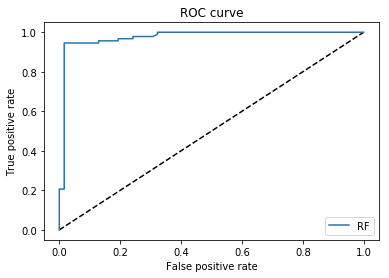

0.9486325385694251


In [8]:
df_aux = df_ffd.dropna()
X = df_aux.iloc[:,:12]
y = df_aux.iloc[:,12:]

X_train, X_test, y_train, y_test = timeseries_train_test_split(X, y, test_size=0.3)

n_estimator = 10000
rf = RandomForestClassifier(max_depth=10, n_estimators=n_estimator,
                            criterion='entropy', random_state=42)
rf.fit(X_train, y_train)

# The random forest model by itself
y_pred_rf = rf.predict_proba(X_test)[:, 1]
y_pred = rf.predict(X_test)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
print(classification_report(y_test, y_pred))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
auc = roc_auc_score(y_true = y_test, y_score = y_pred)
print(auc)

vemos que overfitea, entonces a este modelo le vamos a agregar variables adicionales

<h3>Modelo 2: agregamos X variables</h3>

In [12]:
rsi_windows = [5, 13, 34, 55]
for w in rsi_windows:
    rsi = get_rsi(df_ffd, window=w).squeeze()
    df_ffd[f'rsi_{w}'] = rsi
    
df_ffd.dropna(inplace=True)

df_ffd['log_ret'] = np.log(df_ffd['Close']).diff()

# momentum 
for w in rsi_windows:
    df_ffd[f'mom_{w}'] = df_ffd['Close'].pct_change(w)
    
# vol
for w in rsi_windows:
    df_ffd[f'vol_{w}'] = (df_ffd['log_ret']
                            .rolling(window=w, min_periods=w, center=False)
                            .std())
    
# autocorr
window_autocorr = 50
df_ffd['autocorr_1'] = (df_ffd['log_ret']
                          .rolling(window=window_autocorr, 
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=1), raw=False))

df_ffd['autocorr_2'] = (df_ffd['log_ret']
                          .rolling(window=window_autocorr, 
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=3), raw=False))

df_ffd['autocorr_3'] = (df_ffd['log_ret']
                          .rolling(window=window_autocorr, 
                                   min_periods=window_autocorr, center=False)
                          .apply(lambda x: x.autocorr(lag=5), raw=False))

NameError: name 'FinancialFunctions' is not defined

In [ ]:
Modelo -1: Hacer metalabling del size????
Modelo 2: agregar mas variables (autocorrelacion, rsi?,etc)
Modelo 3: Cross Validation
Modelo 4bis: Metalabeling del Size
Modelo 4: Size (XGBOOST)
    
En todos: feature importance

